In [1]:
# import necessary libraries
import os, sys, glob
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from PIL import Image
from importlib import reload # when you make changes to a .py, force reload imports


# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
import utils.WeightedCrossEntropy as WeightedCrossEntropy
import utils.BuildUNet as BuildUNet
import utils.TileGenerator as TG
import utils.DistanceMap as DistanceMap

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 00422MiB / 40537MiB
  1  | 00003MiB / 40537MiB
  2  | 04476MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:1
---------------------------


# 1) Data Loading

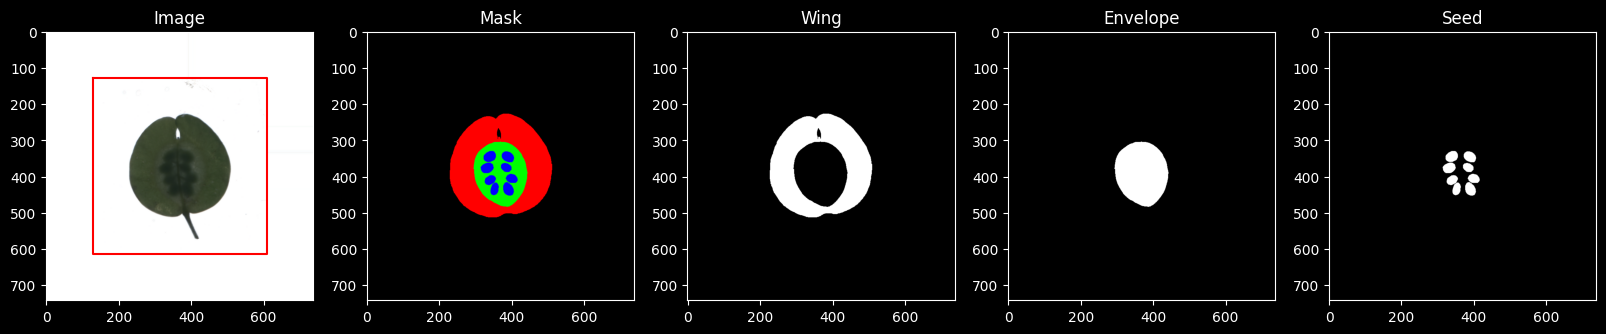

In [2]:
# define options
img_path = '../pennycress_pods/train/train_images_by_pod/'
mask_path = '../pennycress_pods/train/train_masks_by_pod/'
n_pad = 128

# load images and masks into list
mask_names = sorted([os.path.basename(x) for x in glob.glob(mask_path + '*.png')])

pennycress_images = []
pennycress_masks = []

for img_name in mask_names:
    # load image
    image = np.array(Image.open(img_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    pennycress_images.append(image)

    # load mask
    mask = np.array(Image.open(mask_path + img_name))
    mask = (mask / 255.0) # normalize mask
    mask = np.pad(mask, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'constant', constant_values=0) # pad mask w/ constant 0 value
    pennycress_masks.append(mask)

# split masks into wing and pod and seed
wings = [m[:, :, 0] > 0.5 for m in pennycress_masks] # take red channel and booleanize
envelopes = [m[:, :, 1:].sum(-1) > 0.5 for m in pennycress_masks] # "... blue ..."
seeds = [m[:, :, 2] > 0.5 for m in pennycress_masks] # "... green ..."

# create list for multiclass masks
multiclass_masks = []

# add additional channel to pennycress masks for one-hot encoding
for mask in pennycress_masks:
    bg = mask.sum(-1) == 0 # booleanize background
    mask = np.concatenate([bg.reshape(*bg.shape, 1), mask], axis=-1) # add background channel
    multiclass_masks.append(mask)

# plot images and masks
i = np.random.randint(0, len(pennycress_images)) #select random from list of pennycress images
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(pennycress_images[i]); ax[0].set_title('Image')
# plot line around padding
ax[0].plot([n_pad, n_pad, pennycress_images[i].shape[1] - n_pad, pennycress_images[i].shape[1] - n_pad, n_pad],
           [n_pad, pennycress_images[i].shape[0] - n_pad, pennycress_images[i].shape[0] - n_pad, n_pad, n_pad], 'r')
ax[1].imshow(pennycress_masks[i]); ax[1].set_title('Mask')
ax[2].imshow(wings[i], cmap='gray'); ax[2].set_title('Wing')
ax[3].imshow(envelopes[i], cmap='gray'); ax[3].set_title('Envelope')
ax[4].imshow(seeds[i], cmap='gray'); ax[4].set_title('Seed')
plt.show()

# 2) Data Generation

Plotting training examples...


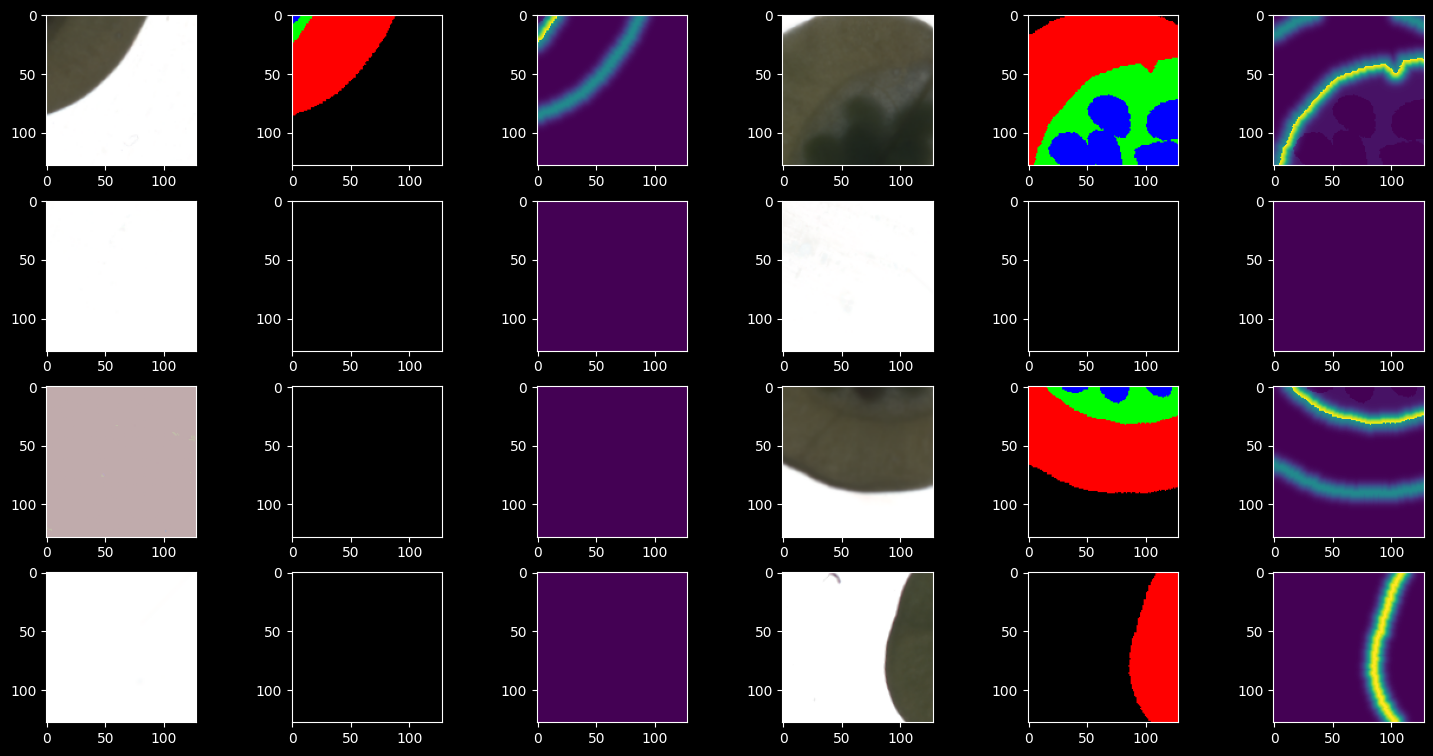

Plotting validation examples...


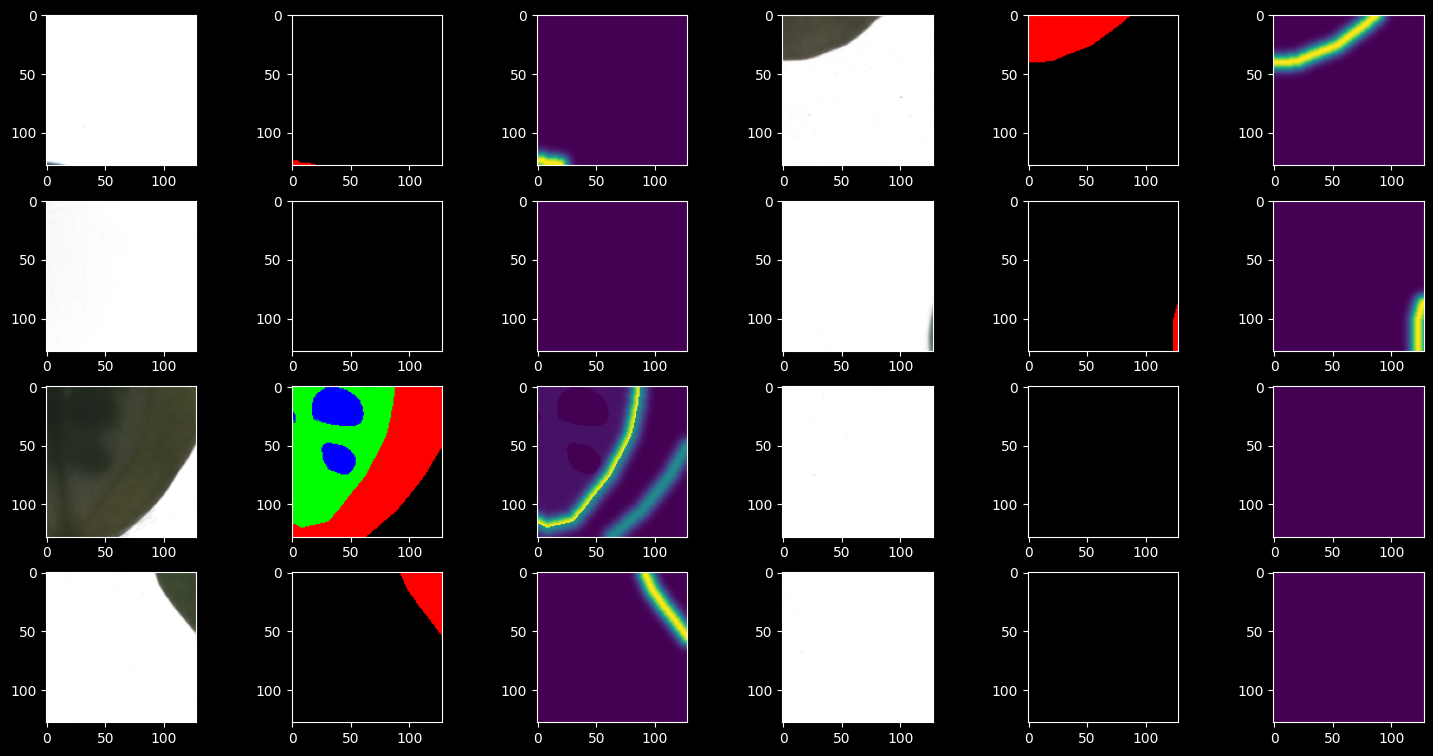

In [7]:
# whenever you run cell, re-import TG as a module
reload(TG)
reload(DistanceMap)

# options
images = pennycress_images
masks = multiclass_masks
tile_size = 128
train_prop = 0.8
distance_weights = True

#create train/val splits by image
p = np.random.permutation(len(images))
train_idx = p[:int(train_prop*len(images))]
val_idx = p[int(train_prop*len(images)):]



# instantiate tilegenerator class
train_generator = TG.TileGenerator(
    images=[images[i] for i in train_idx],
    masks=[masks[i] for i in train_idx], 
    tile_size=tile_size, 
    split='train',
    n_pad = n_pad,
    distance_weights=distance_weights
    )

val_generator = TG.TileGenerator(
    images=[images[i] for i in val_idx],
    masks=[masks[i] for i in val_idx], 
    tile_size=tile_size, 
    split='val',
    n_pad = n_pad,
    distance_weights=distance_weights
    )

#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w)

    else:
        img, msk = train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
        
        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w)

    else:
        img, msk = val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]

        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

# Build U-Net

In [8]:
reload(BuildUNet)

model_kwargs = {
    'layer_sizes': [32, 64, 128],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None
}

unet = BuildUNet.UNet(**model_kwargs).to(device)

# Implement the Backward Pass/Training

In [9]:
# define our loss function, optimizer
reload(WeightedCrossEntropy)
if distance_weights:
    loss_function = WeightedCrossEntropy.WeightedCrossEntropy(device=device)
else:
    loss_function = torch.nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [10]:
# training loop
import time
from torch.utils.data import DataLoader

# options 
batch_size = 32
batches_per_eval = 1000

# learning rate schedule options
warmup_iters = 10000 # number of iterations to reach max learning rate
lr_decay_iters = 50000 # number of iterations to reach min learning rate
max_lr = 1e-3
min_lr = 1e-5
max_iters = 100000 # total number of iterations to train

# gradient clipping options
clip_value = 1

# log options
log_interval = 1 # iterations between logging batch statistics
eval_interval = 1000 # checkpointing interval
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'
iter_update = 'step {0}: train loss {1:.4e}, val loss {2:.4e}\r'

# more options
best_val_loss = None # initialize best validation loss
early_stop = 50 # set value for early stopping counter
t0 = time.time() # start timer
last_improved = 0 # start early stopping counter
iter_num = 0 # initialize iteration counter
n_workers = 32 # number of workers for dataloader

# learning rate decay scheduler (cosine with warmup) -- Thanks Andrej Karpathy
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return max_lr * it / warmup_iters
    
    # 2) if it > lr_decay_iters, return min learning rate
    
    if it > lr_decay_iters + warmup_iters:
        return min_lr
    
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (max_lr - min_lr)

# refresh log
with open(log_path, 'w') as f: 
    f.write(f'iter_num,train_loss,val_loss\n')

# keep training until break
while True:

    #
    # checkpoint
    #

    # shuffle dataloaders
    train_loader = DataLoader(
        train_generator, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True)
    val_loader = DataLoader(
        val_generator, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True)

    # estimate loss
    unet.eval()
    with torch.no_grad():
        train_loss, val_loss = 0, 0
        with tqdm(total=batches_per_eval, desc=' Eval') as pbar:
            for (xbt, ybt), (xbv, ybv) in zip(train_loader, val_loader):
                xbt, ybt = xbt.to(device), ybt.to(device)
                xbv, ybv = xbv.to(device), ybv.to(device)
                train_loss += loss_function(unet(xbt), ybt).item()
                val_loss += loss_function(unet(xbv), ybv).item()
                pbar.update(1)
                if pbar.n == pbar.total:
                    break
        train_loss /= batches_per_eval
        val_loss /= batches_per_eval
    unet.train()

    # update user
    print(iter_update.format(iter_num, train_loss, val_loss)) 

    # update log
    with open(log_path, 'a') as f: 
        f.write(f'{iter_num},{train_loss},{val_loss}\n')

    # checkpoint model
    if iter_num > 0:
        checkpoint = {
            'model': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'kwargs': model_kwargs,
            'iter_num': iter_num,
            'best_val_loss': best_val_loss,
            'train_ids': train_idx,
            'val_ids': val_idx,
        }
        torch.save(checkpoint, chckpnt_path.format(iter_num))

    # book keeping
    if best_val_loss is None:
        best_val_loss = val_loss

    if iter_num > 0:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            last_improved = 0
            print(f'*** validation loss improved: {best_val_loss:.4e} ***')
        else:
            last_improved += 1
            print(f'validation has not improved in {last_improved} steps')
        if last_improved > early_stop:
            print()
            print(f'*** no improvement for {early_stop} steps, stopping ***')
            break

    # --------
    # backprop
    # --------

    # shuffle dataloaders
    train_loader = DataLoader(
        train_generator, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True)

    # iterate over batches
    with tqdm(total=eval_interval, desc='Train') as pbar:
        for xb, yb in train_loader:

            # update the model
            xb, yb = xb.to(device), yb.to(device)

            loss = loss_function(unet(xb), yb)

            if torch.isnan(loss):
                print('loss is NaN, stopping')
                break

            loss.backward()

            # gradient clipping

            # torch.nn.utils.clip_grad_norm_(unet.parameters(), clip_value)
            # for p in unet.parameters():
            #     p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))


            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            # update book keeping
            pbar.update(1)
            iter_num += 1
            if pbar.n == pbar.total:
                break

    # break once hitting max_iters
    if iter_num > max_iters:
        print(f'maximum iterations reached: {max_iters}')
        break


 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 0: train loss 7.7857e+00, val loss 8.2111e+00


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 1000: train loss 9.5201e-01, val loss 1.0487e+00
*** validation loss improved: 1.0487e+00 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 2000: train loss 7.2929e-01, val loss 7.2794e-01
*** validation loss improved: 7.2794e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 3000: train loss 7.0436e-01, val loss 7.3040e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 4000: train loss 6.7039e-01, val loss 6.9660e-01
*** validation loss improved: 6.9660e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 5000: train loss 6.9332e-01, val loss 7.0599e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

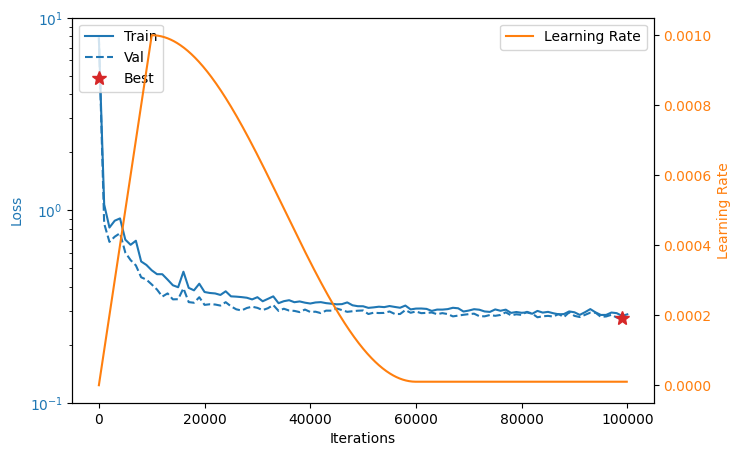

In [7]:
# parse logs
logs = []
with open('../logs/log.csv', 'r') as f:
    logs = f.readlines()
    logs = [l.strip() for l in logs][1:]
logs = [l.split(',') for l in logs]
logs = np.array(logs).astype(float)
iterations, train_loss, val_loss = logs.T
iterations = iterations.astype(int)

iters = np.arange(0, iterations.max(), 100)
lrs = [get_lr(it) for it in iters]

# get best model
best_iter = iterations[np.argmin(val_loss)]

# plot
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

# losses
ax.semilogy(iterations, train_loss, '-', color='tab:blue', label='Train')
ax.semilogy(iterations, val_loss, '--', color='tab:blue', label='Val')
ax.semilogy(best_iter, min(val_loss), '*', color='tab:red', label='Best', markersize=10)
ax.set_ylabel('Loss', color='tab:blue')
ax.set_xlabel('Iterations')
ymin, ymax = ax.get_ylim()
ymin = 10 ** int(np.log10(ymin) - 1)
ymax = 10 ** int(np.log10(ymax) + 1)
ax.set_ylim(ymin, ymax)
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.legend(loc='upper left')

# learning rate
ax2 = ax.twinx()
ax2.plot(iters, lrs, '-', color='tab:orange', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Learning Rate', color='tab:orange')
ax2.legend(loc='upper right')

plt.show()

# Plot Input / Prediction Pairs on Val. Images

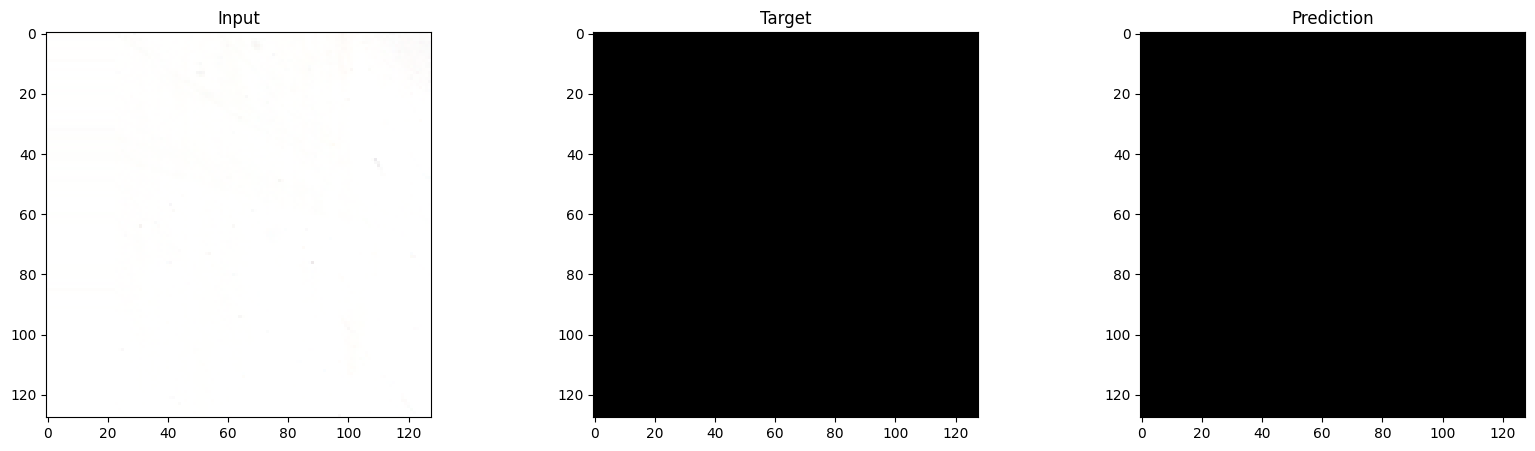

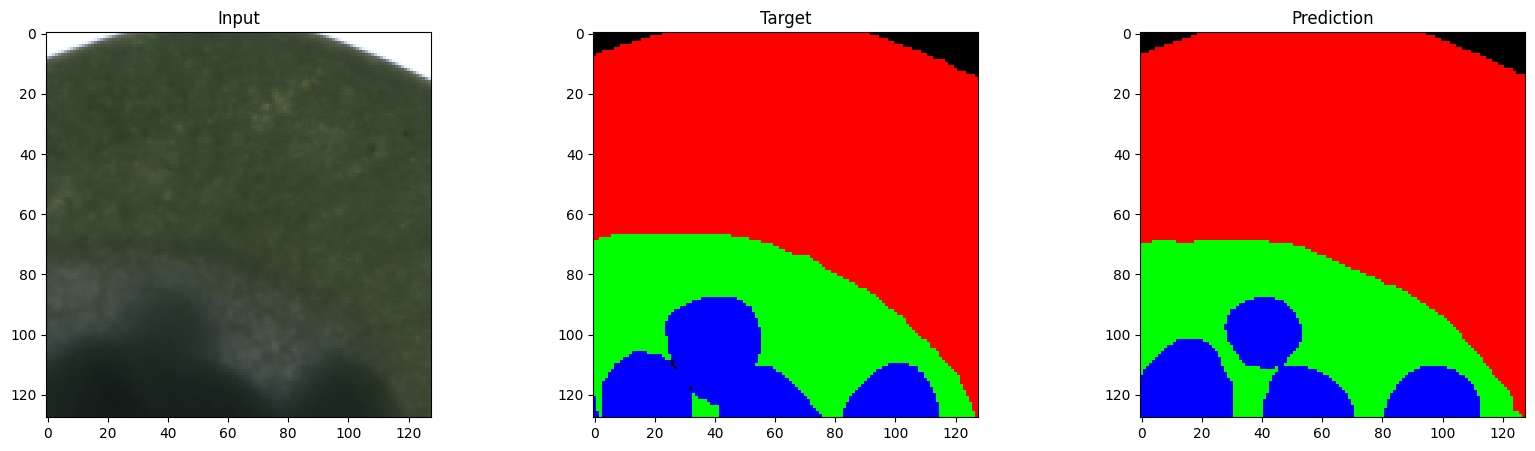

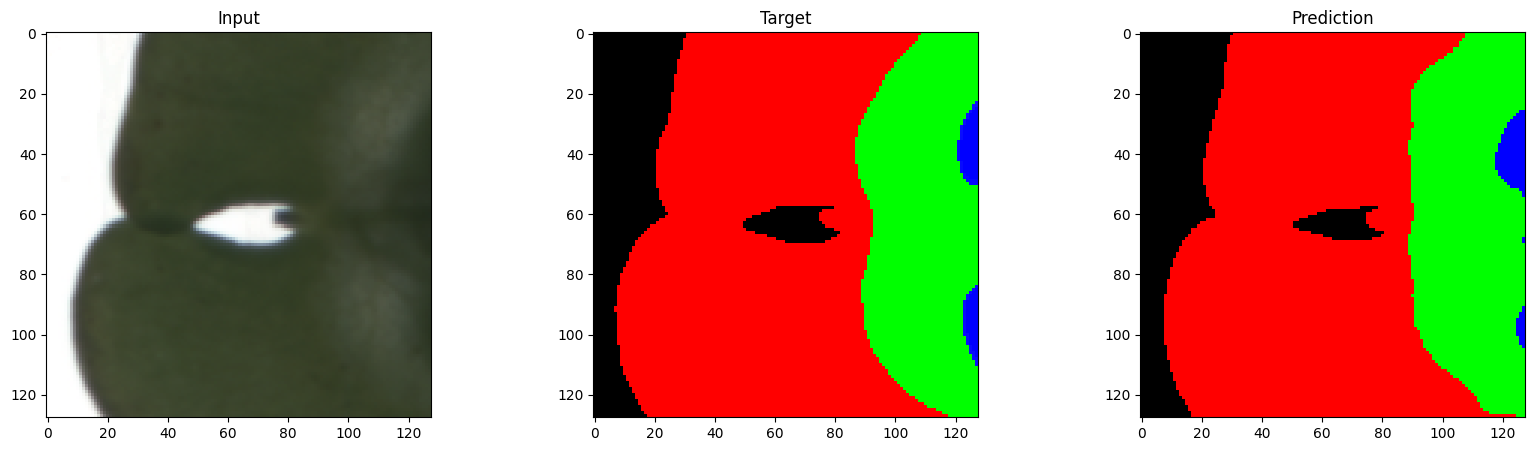

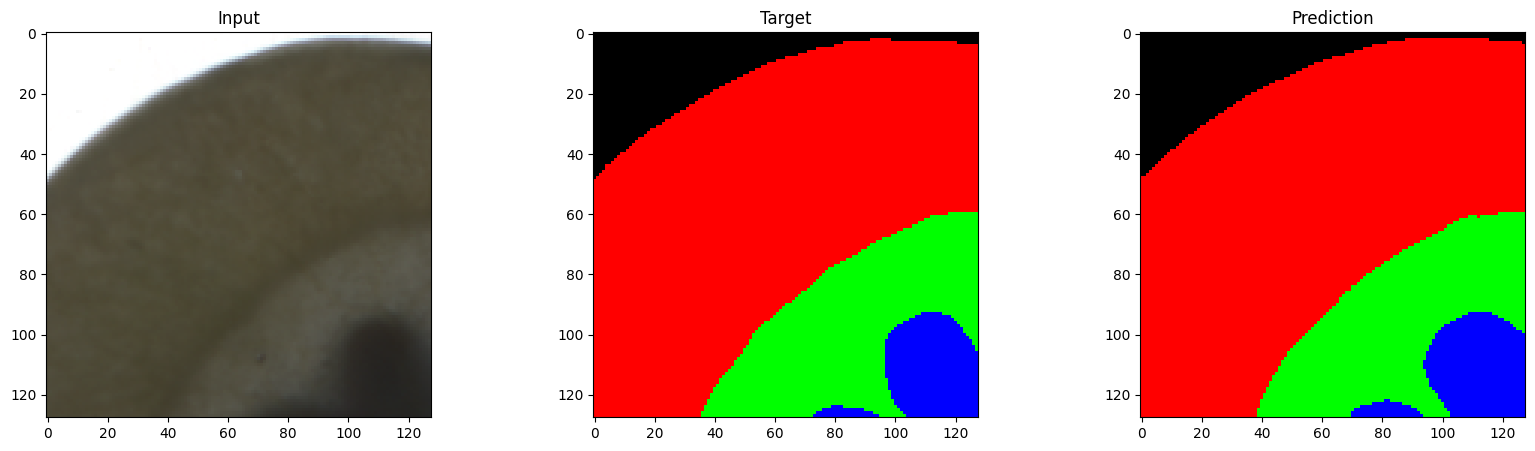

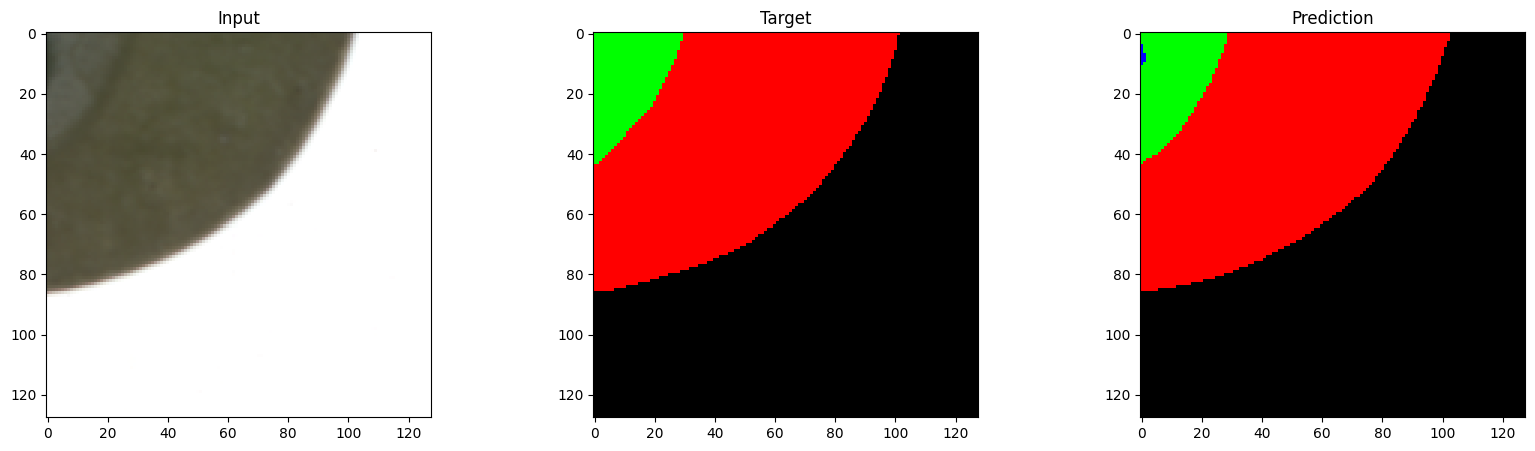

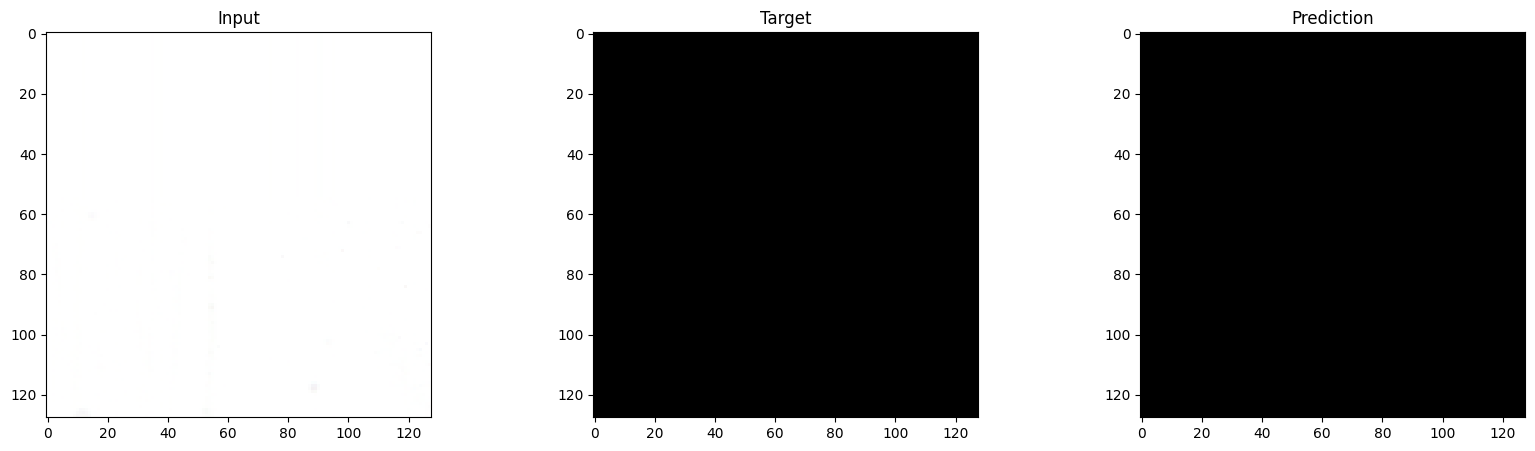

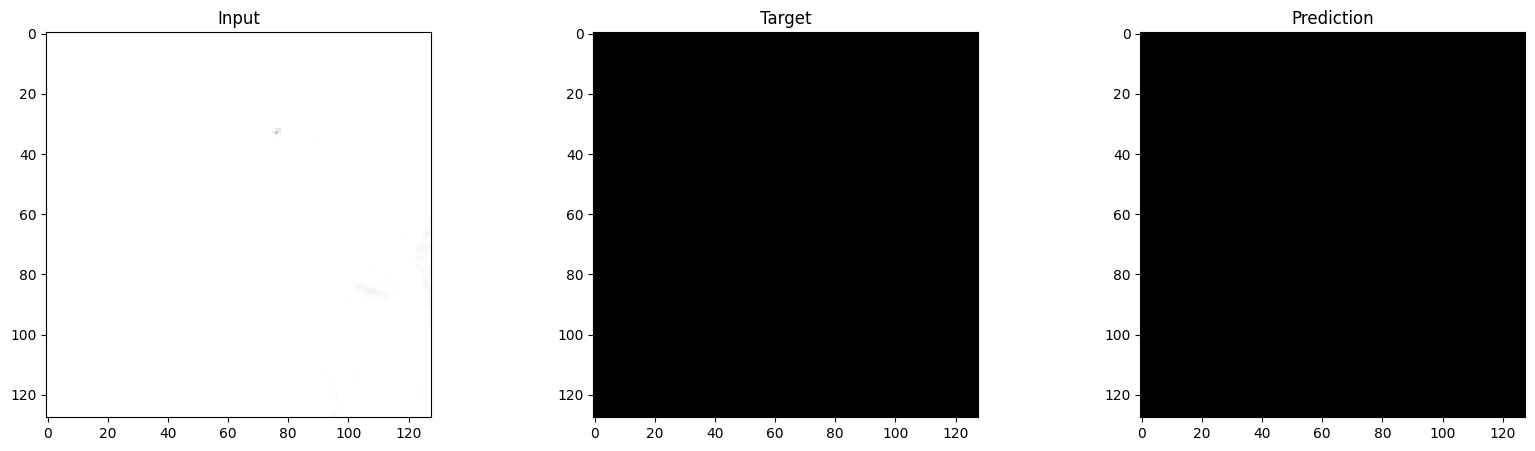

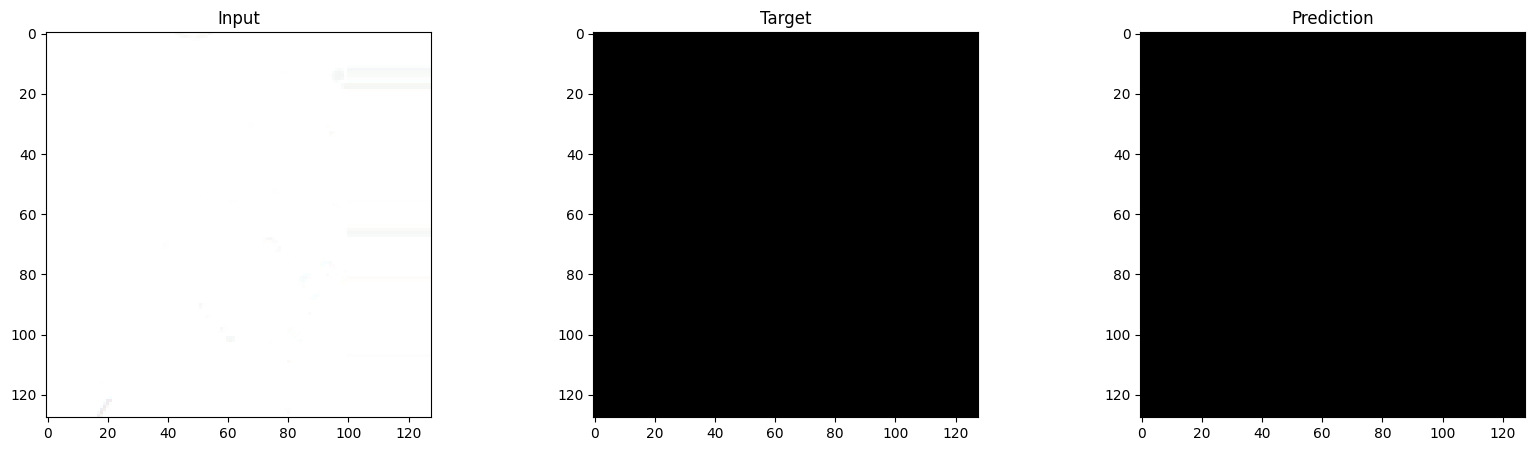

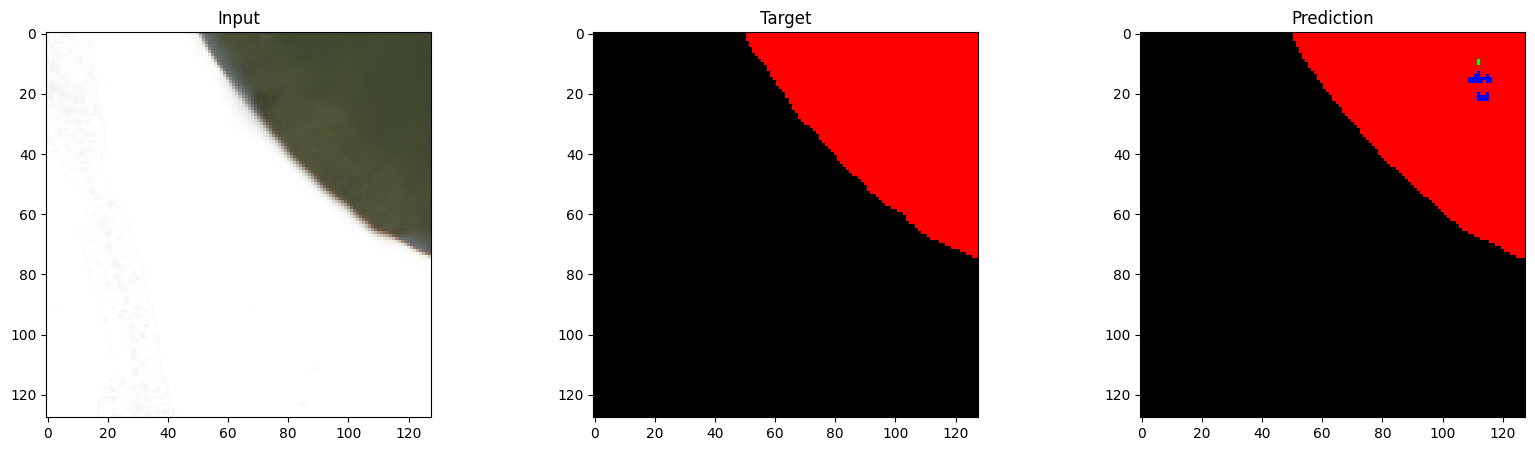

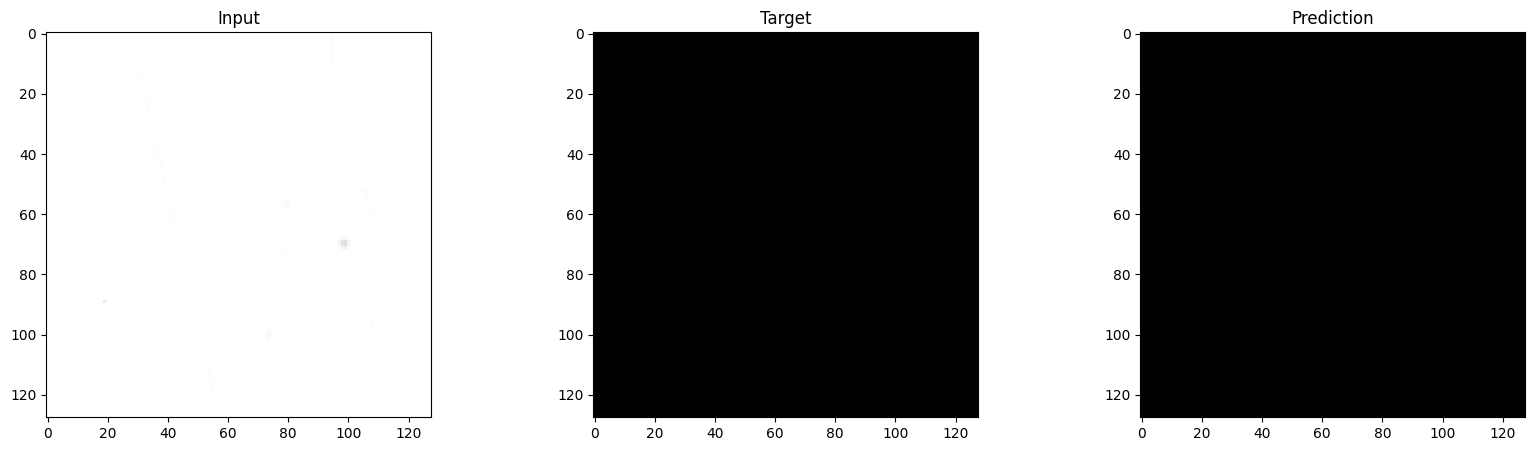

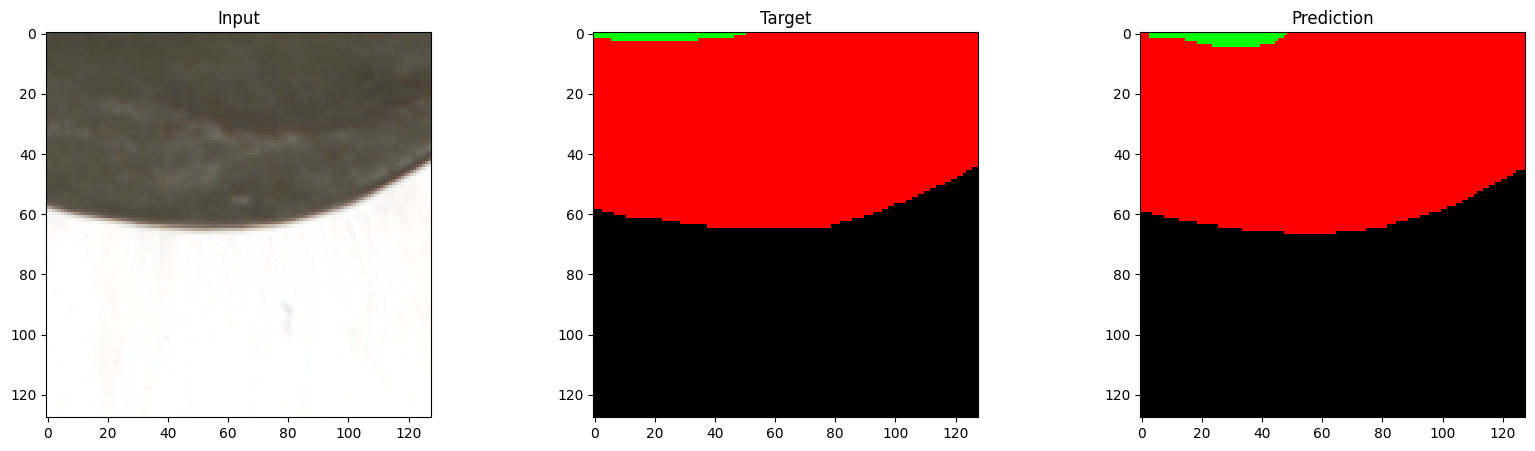

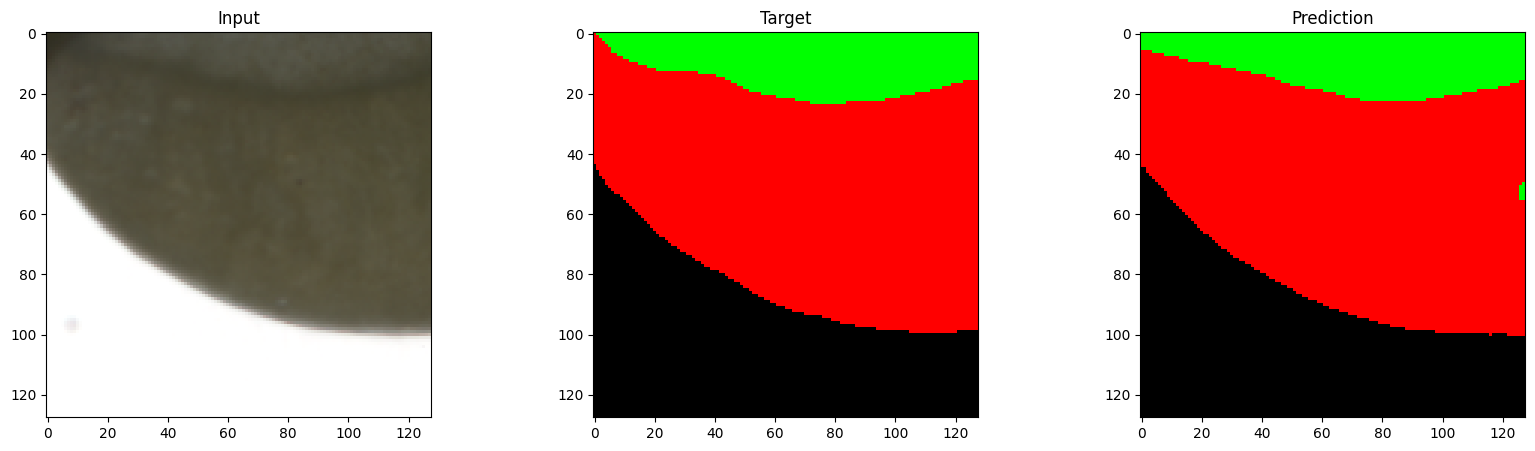

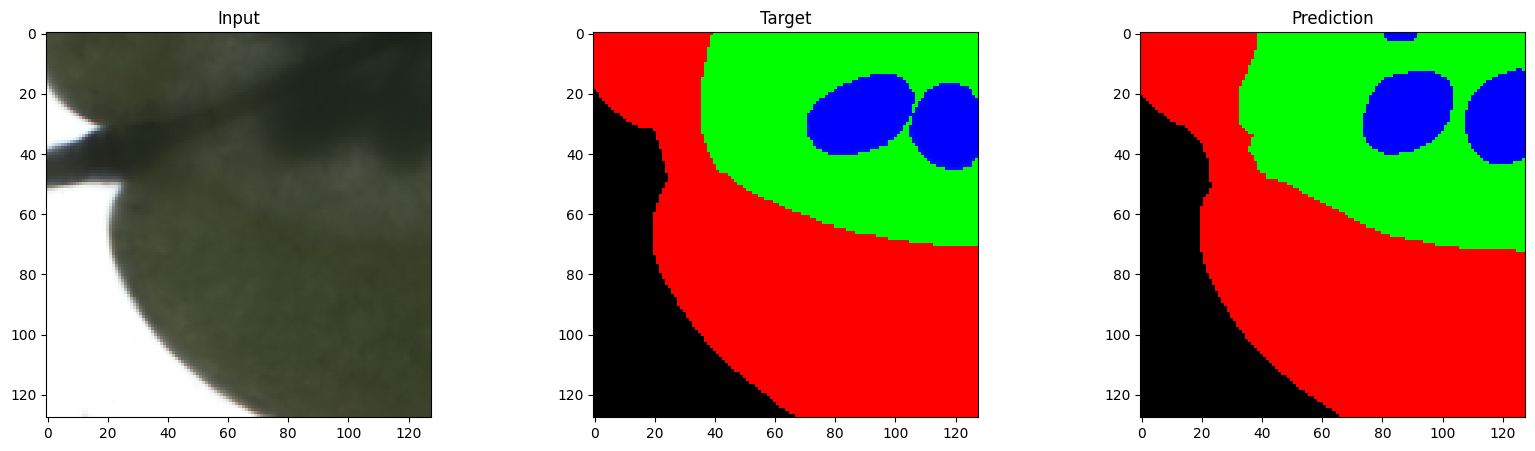

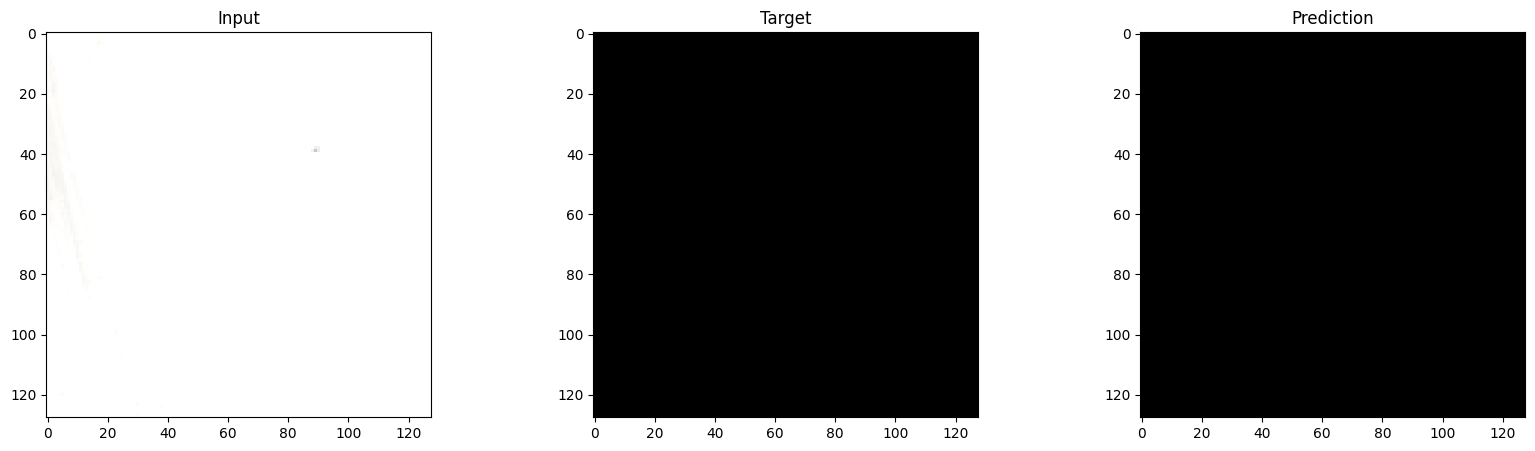

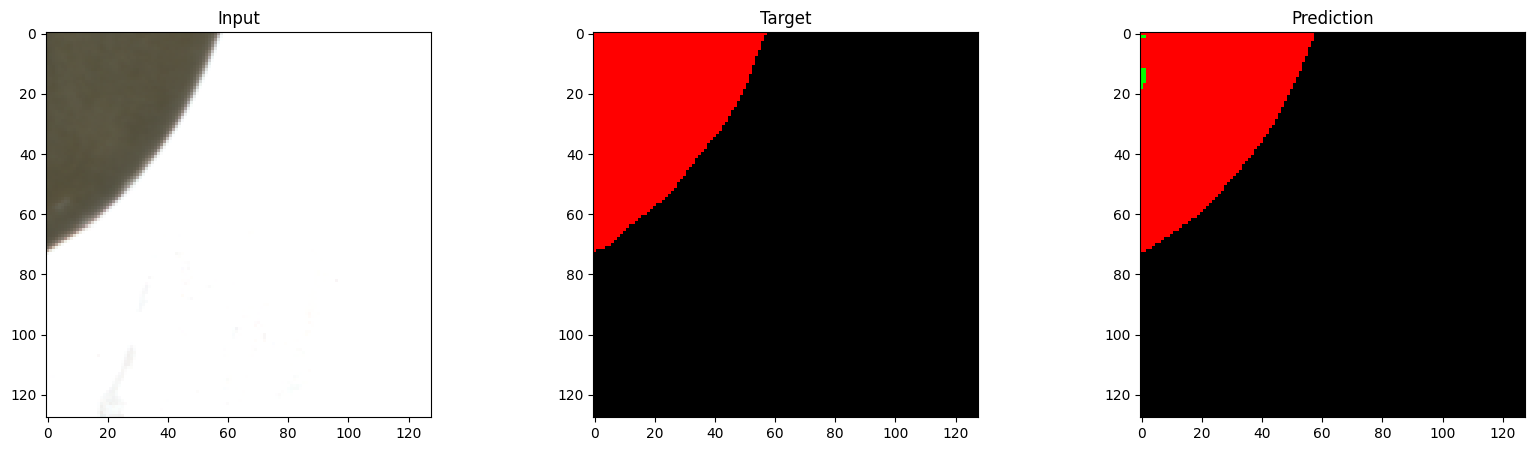

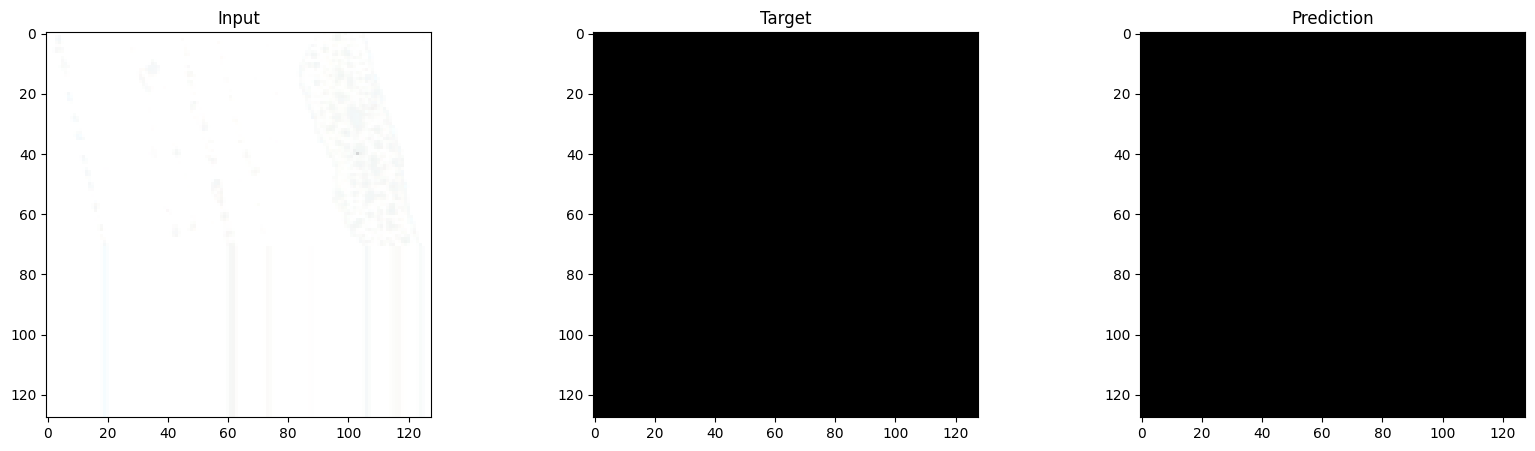

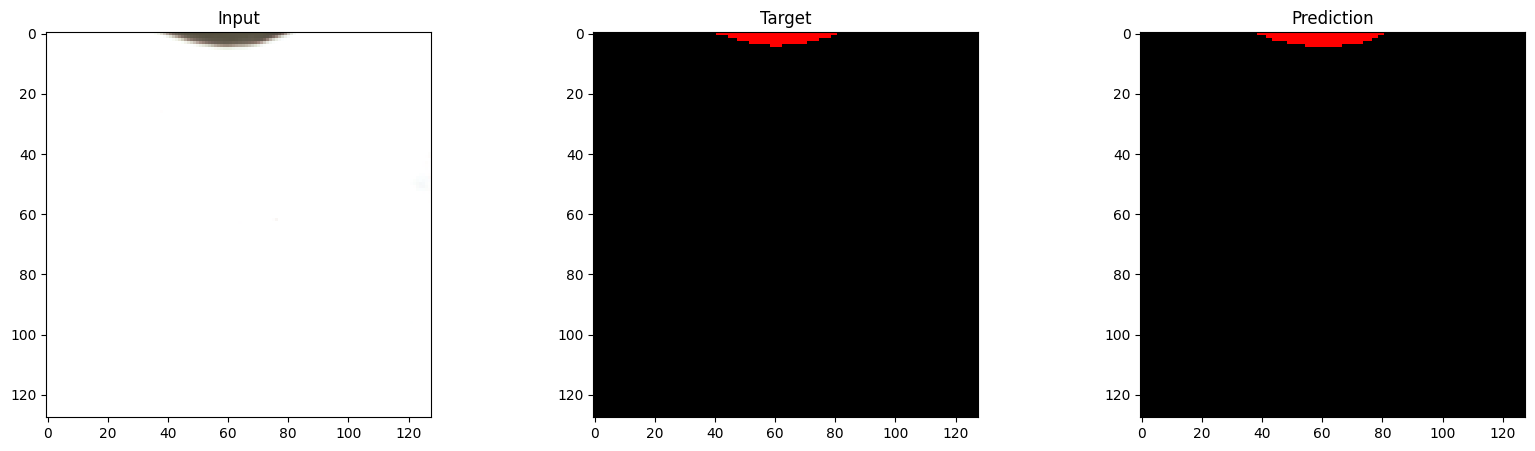

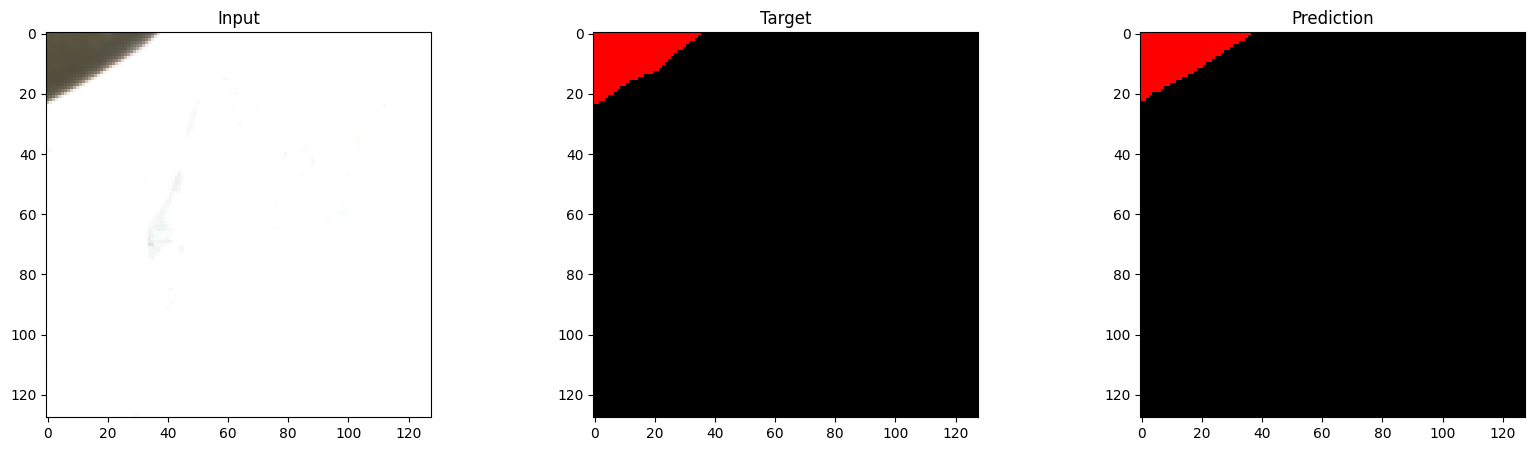

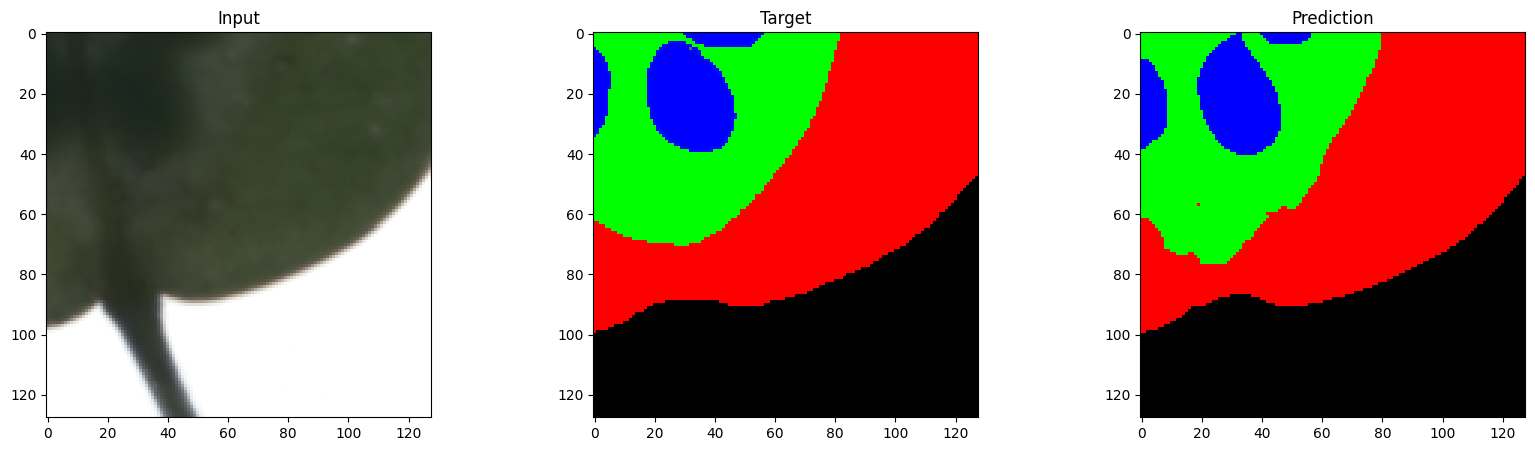

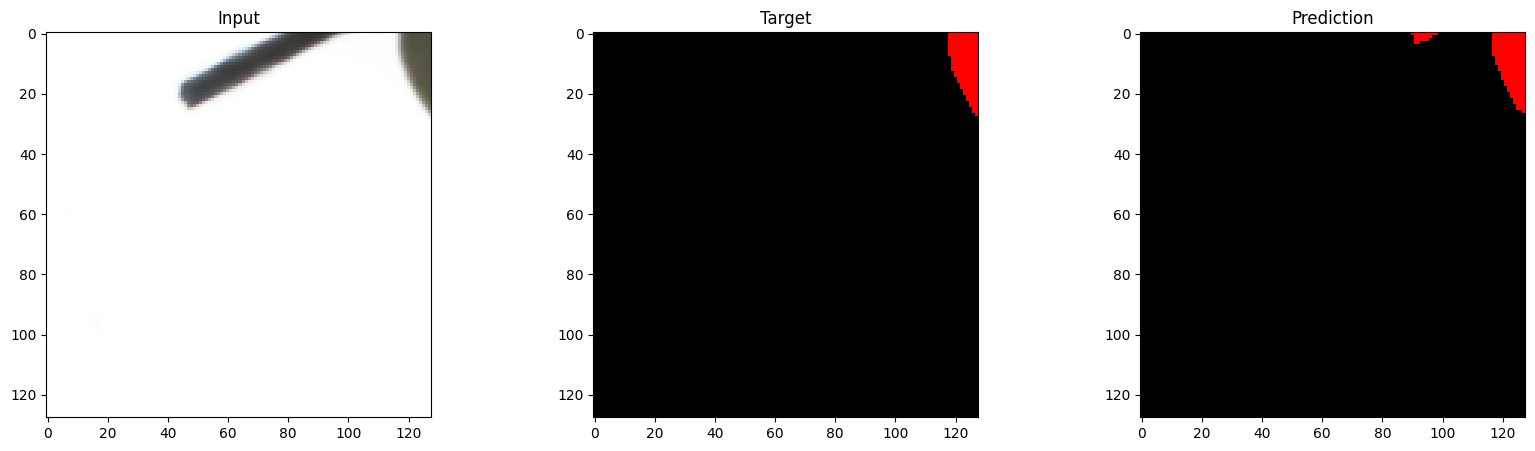

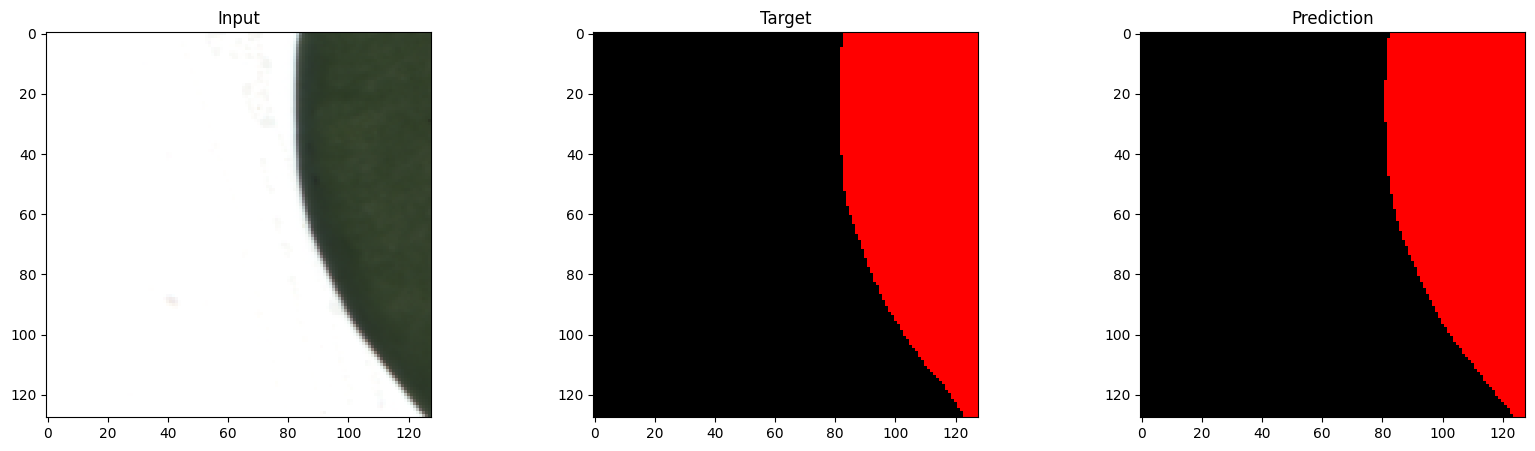

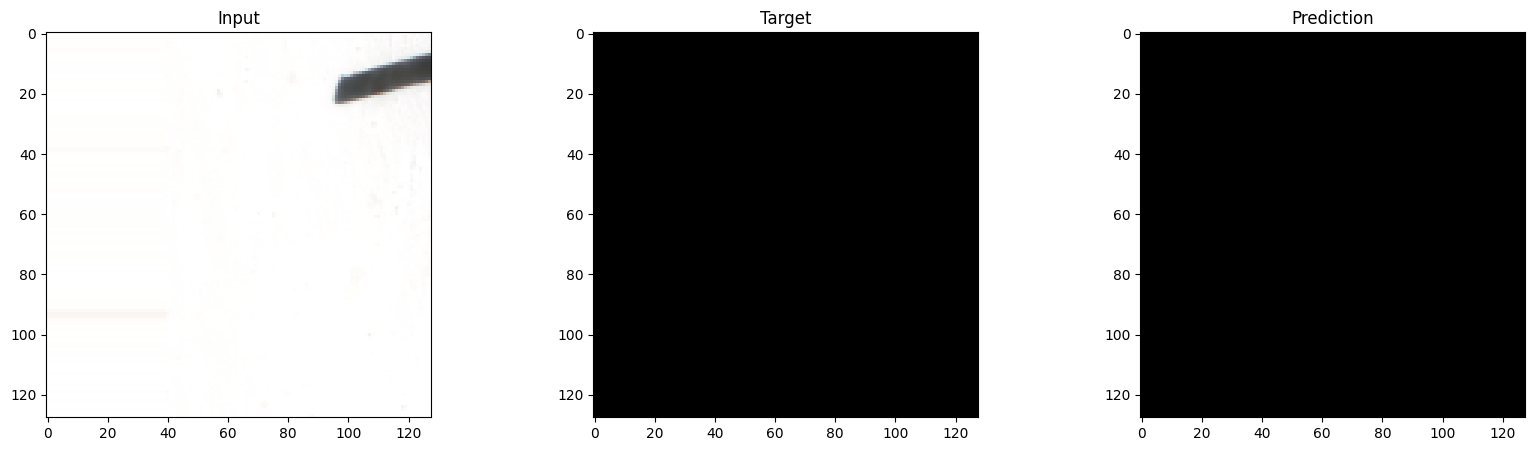

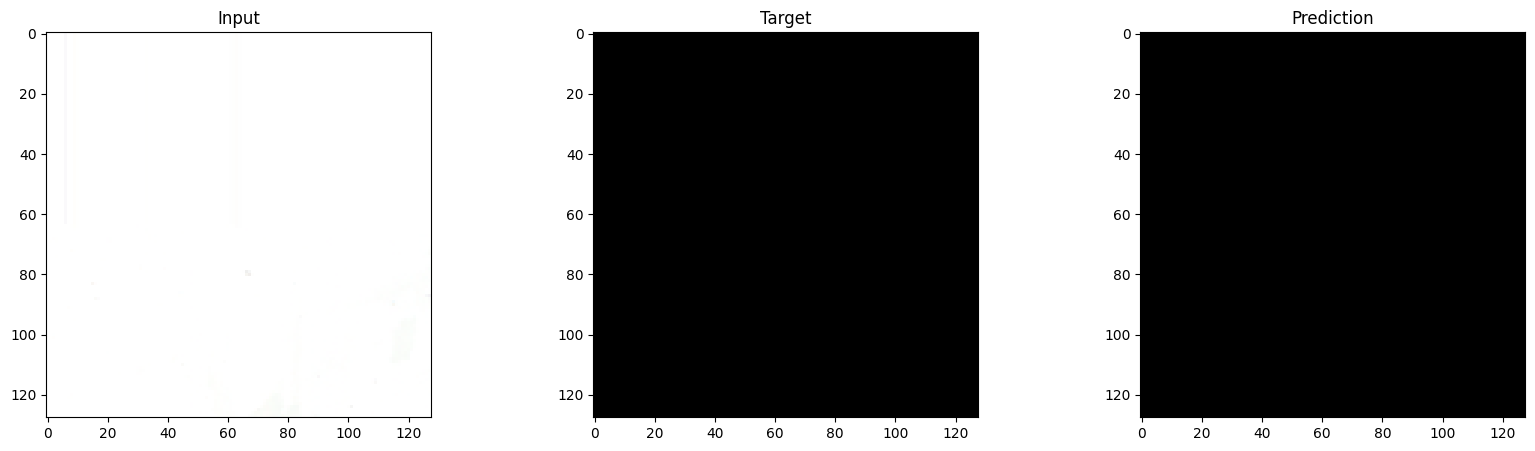

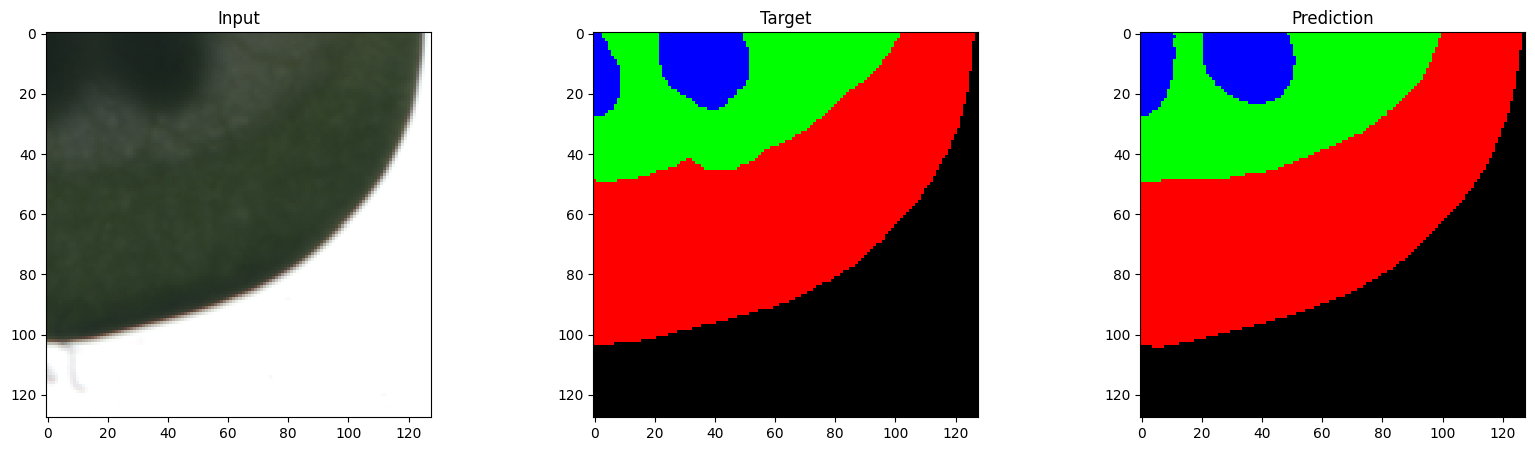

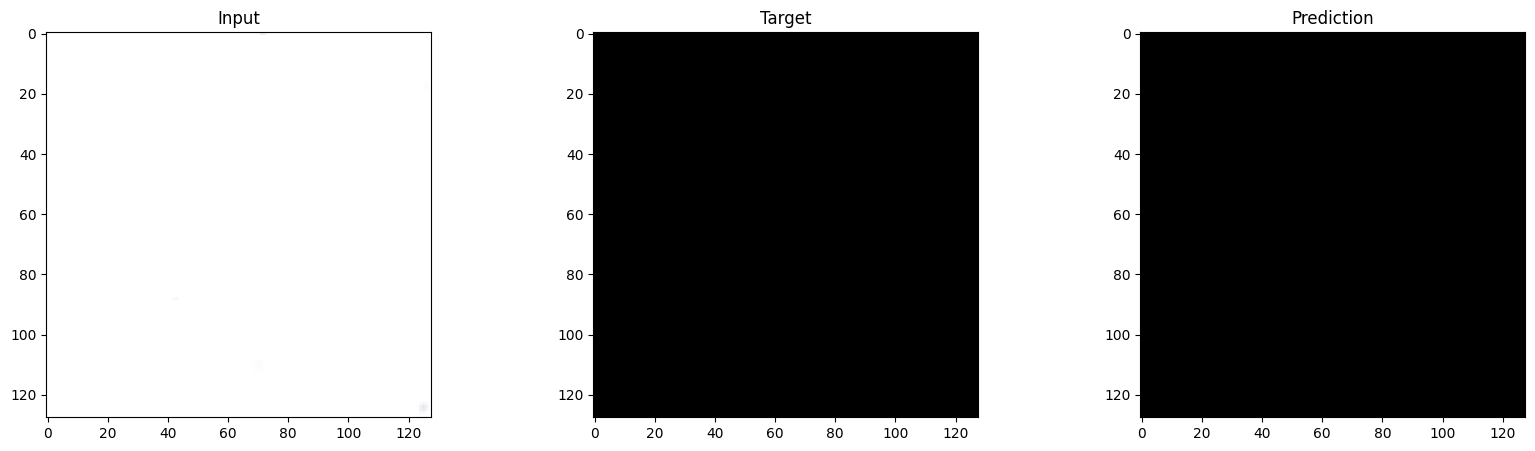

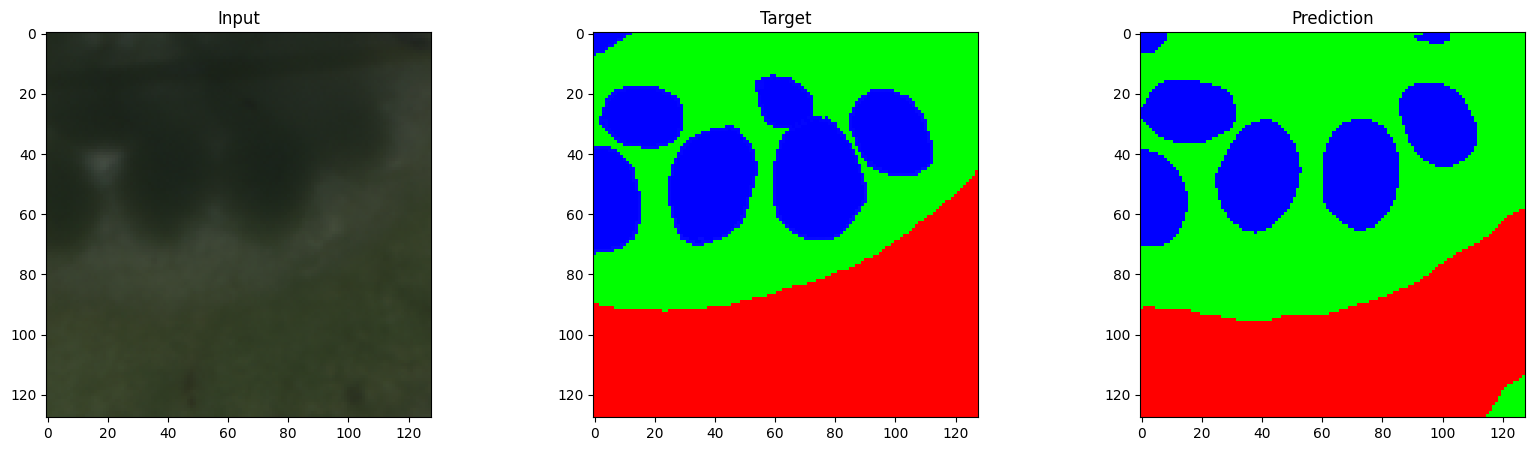

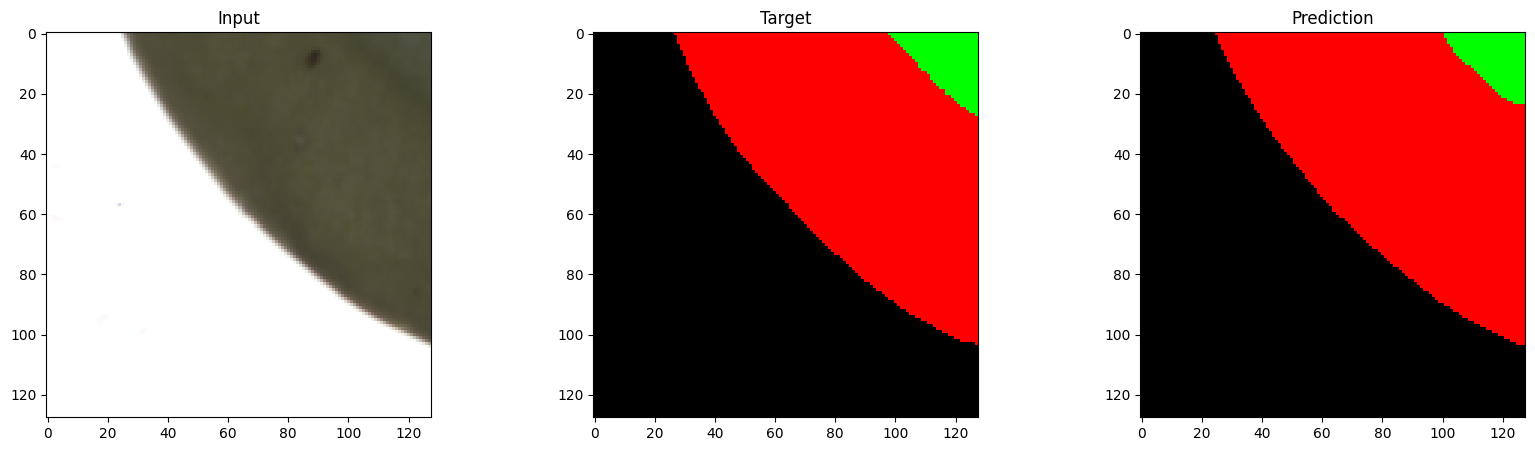

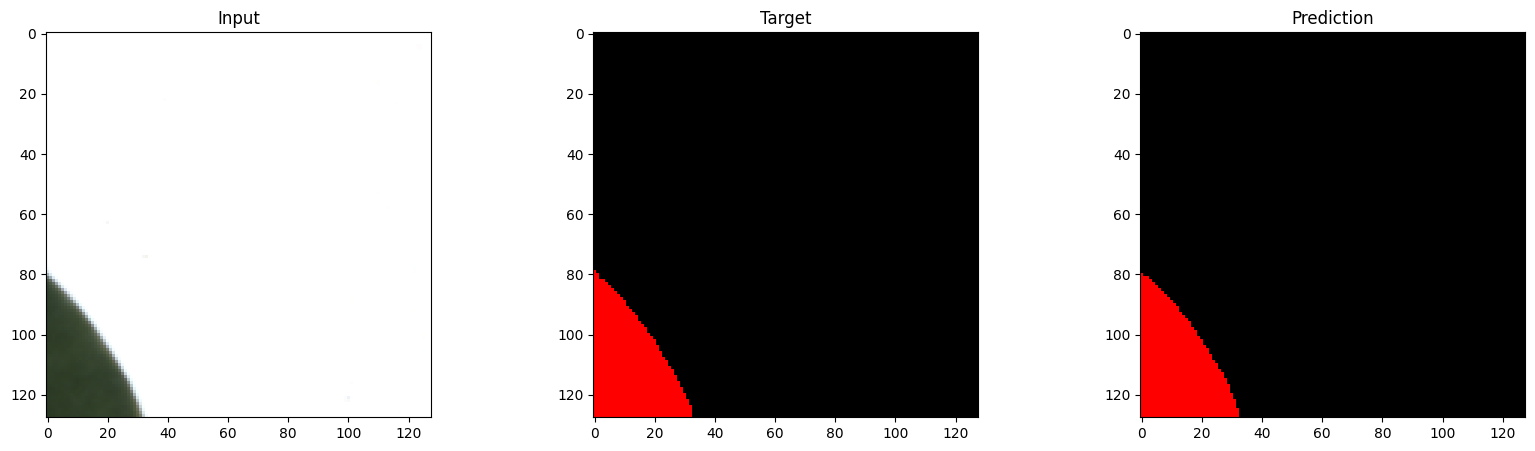

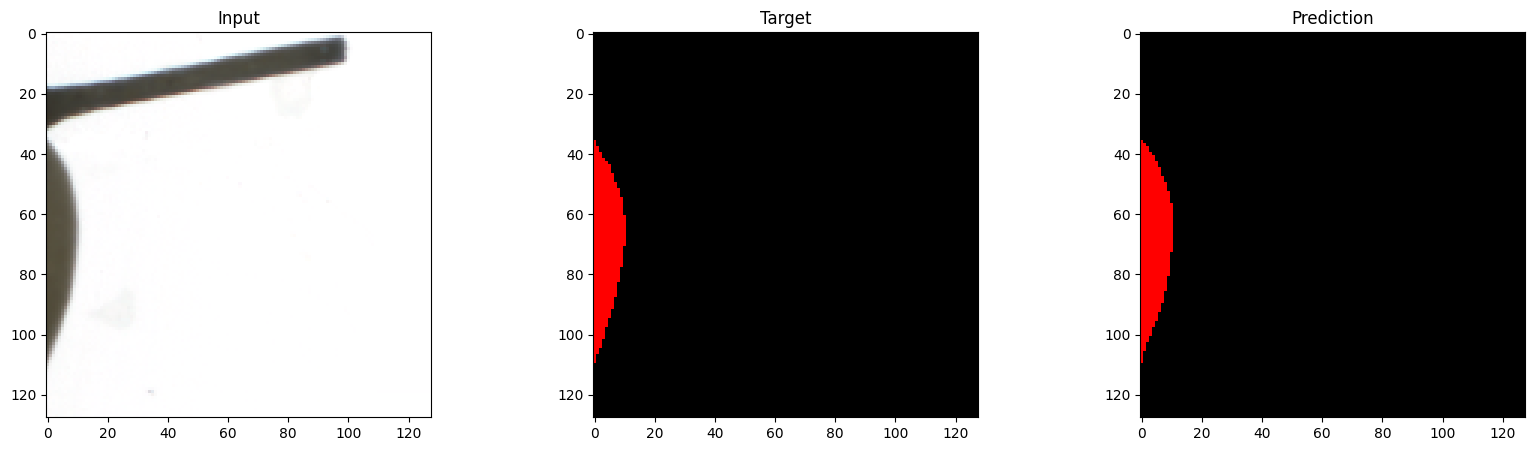

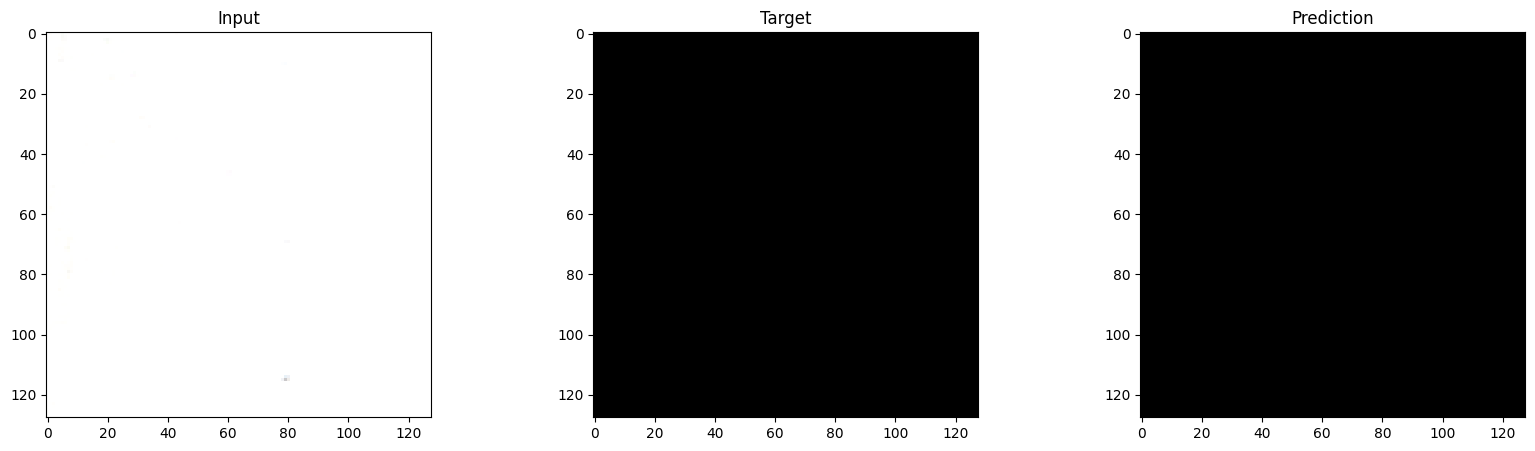

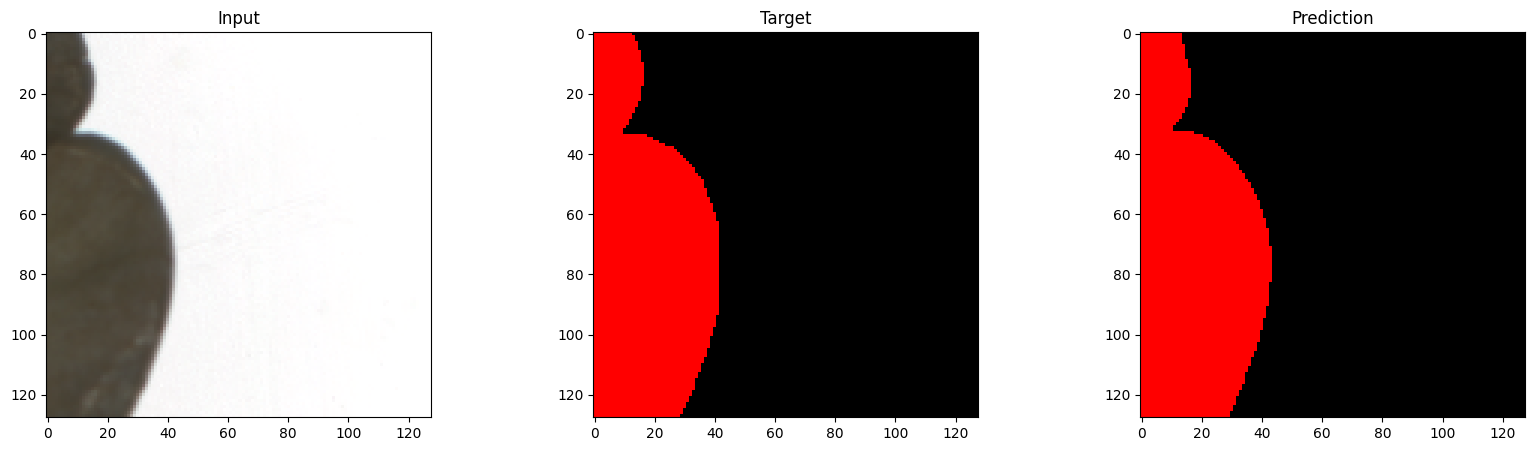

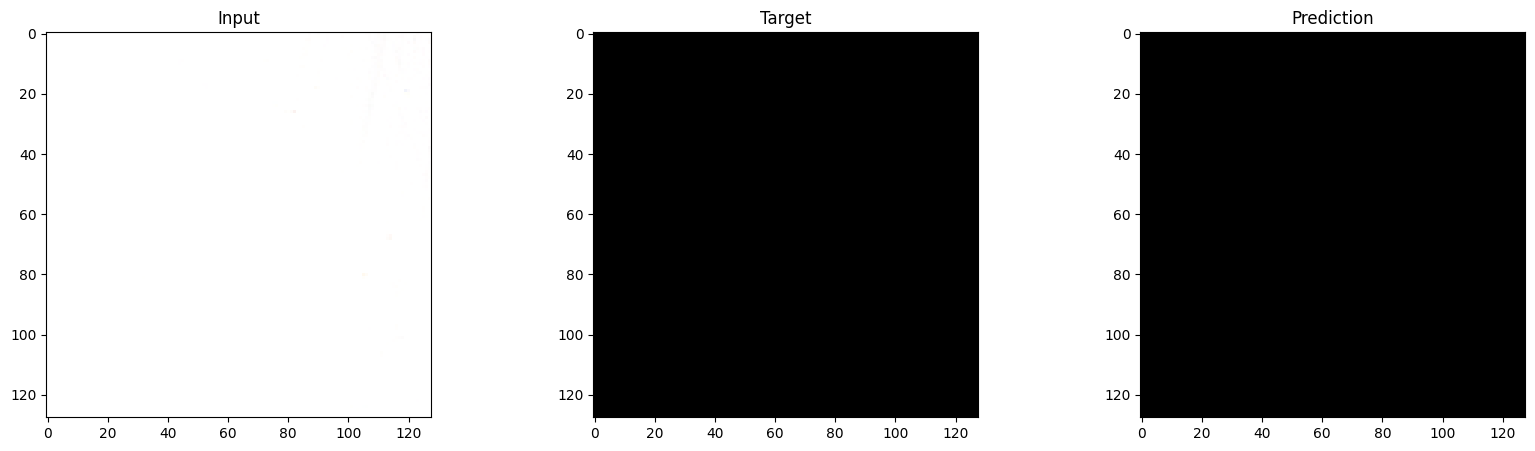

In [8]:
# options
num_plot = 32
rand_idx = np.random.randint(len(val_loader), size = num_plot)


# get random validation batch
(xb, yb) = next(iter(val_loader))
xb, yb = xb.to(device), yb.to(device)[:, :-1, :, :] # remove weight mask

# make prediction with unet
yb_pred = unet(xb).to(device)
yb_pred = torch.nn.functional.softmax(yb_pred, dim=1)

# convert to cpu, numpy, and change channels for visualization
xb_numpy = xb.detach().cpu().permute(0, 2, 3, 1).numpy()
yb_numpy = yb.detach().cpu().permute(0, 2, 3, 1).numpy()[:, :, :, 1:]
yb_pred_numpy = yb_pred.detach().cpu().permute(0, 2, 3, 1).numpy()

# convert predicted probabilities to predicted classes and retain four channels
yb_pred_numpy = np.argmax(yb_pred_numpy, axis=3)
preds = np.zeros(yb_pred_numpy.shape + (4,))
for i in range(4):
    preds[:, :, :, i] = yb_pred_numpy == i
yb_pred_numpy = preds[:, : , :, 1:]

# yb_pred_numpy = np.concatenate([yb_pred_numpy[:, :, :, None] == i for i in range(4)], axis = 3).astype(int)
# yb_pred_numpy = yb_pred_numpy[:, :, :, 1:]

# plot images and masks
for i in range(num_plot):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(xb_numpy[i]); ax[0].set_title('Input')
    ax[1].imshow(yb_numpy[i]); ax[1].set_title('Target')
    ax[2].imshow(yb_pred_numpy[i]); ax[2].set_title('Prediction')
    plt.show()
